I have used the following methods.

* I used a model created with <b>ConvMixer </b> blocks [1,2],
* <b>gelu</b> activation function during the feature extraction stage,
* Used <b>tf.data</b> for input pipeline,
* 10 Kfold cross-validation,
* I split the full data into train (6563 images), validation (729 images) and test (1822 images),
* Applying ensemble method to 10-fold test predictions



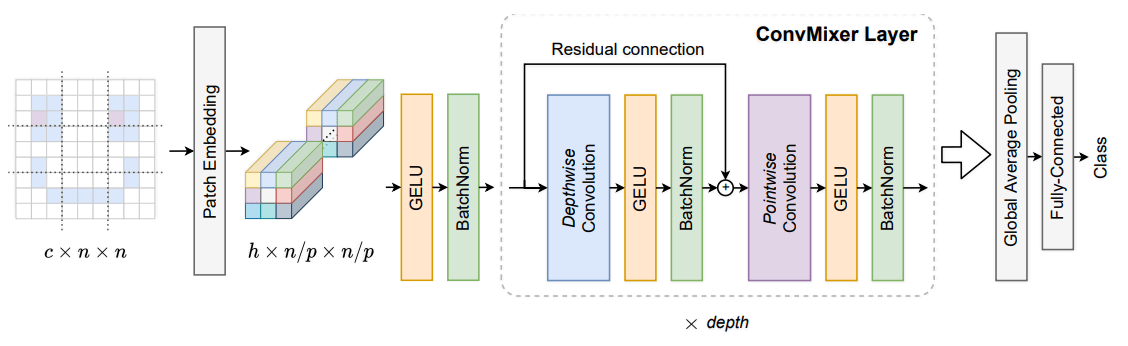

<i> ConvMixer Layer from the paper [1]</i>

## Test Set Predictions
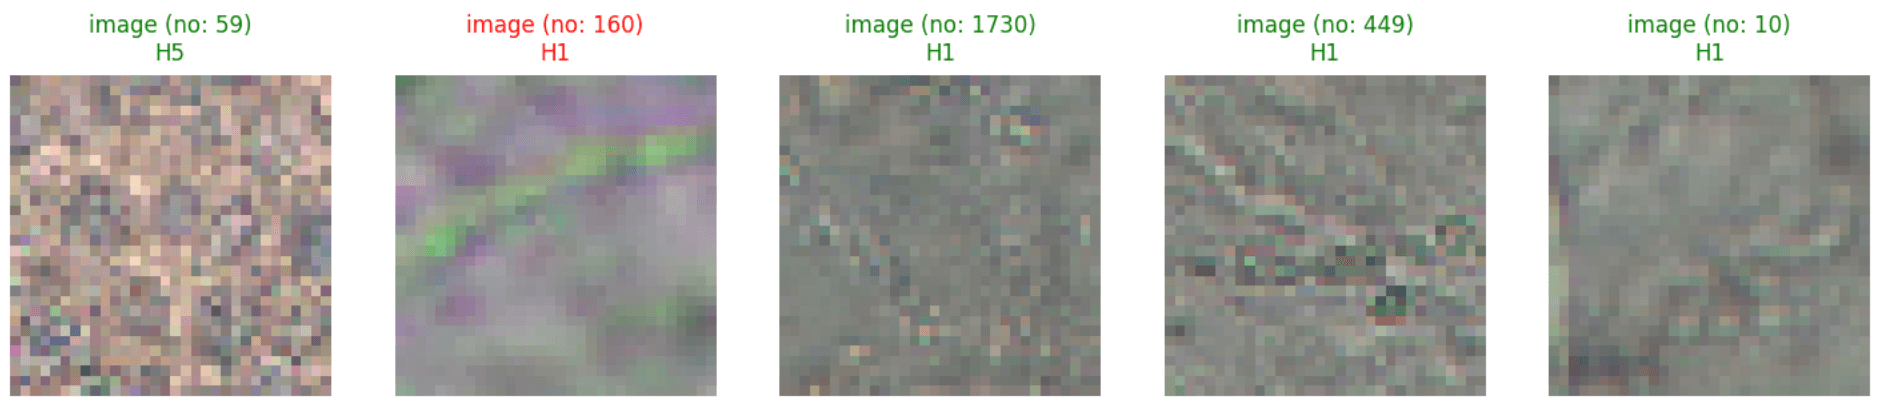
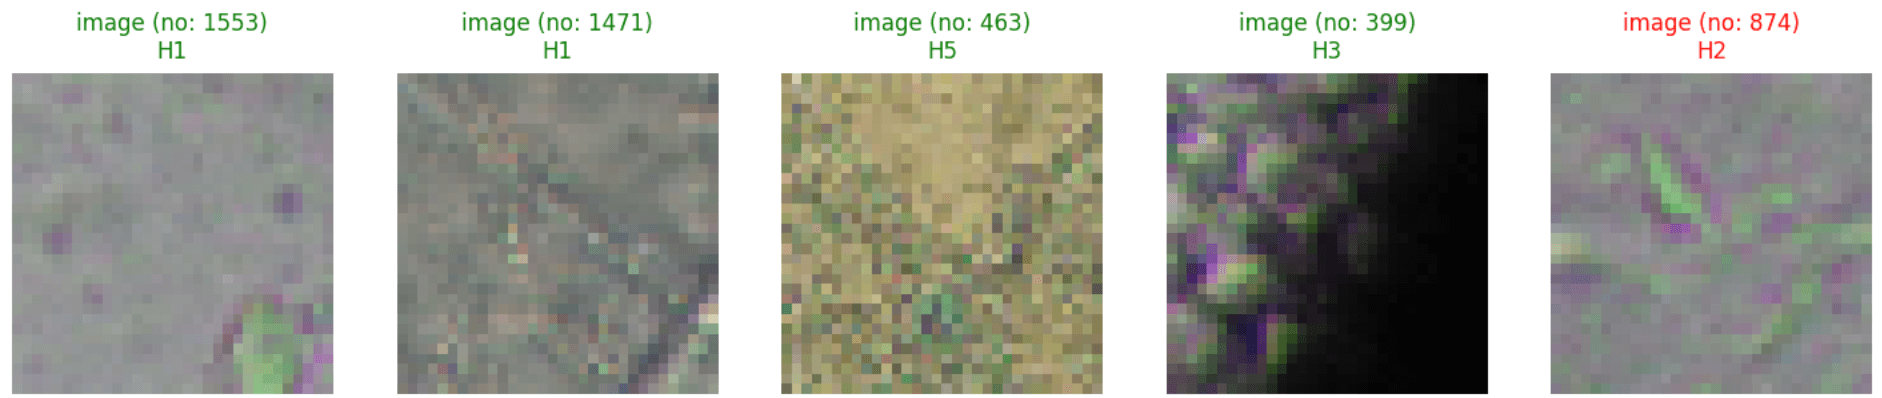


## My Another Projects
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)


## References
1. Trockman, A., & Kolter, J. Z. (2022). Patches Are All You Need? (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2201.09792
2. https://keras.io/examples/vision/convmixer

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

IMG_SIZE = 32, 32
BATCH_SIZE = 128
SEED = 9
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Preprocessing </span>


In [2]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


data_h1 = create_images_list('/kaggle/input/defungi/H1')
data_h2 = create_images_list('/kaggle/input/defungi/H2')
data_h3 = create_images_list('/kaggle/input/defungi/H3')
data_h5 = create_images_list('/kaggle/input/defungi/H5')
data_h6 = create_images_list('/kaggle/input/defungi/H6')

# look-up table
fungus_classes = {0:'H1', 1 : 'H2', 2 : 'H3', 3 : 'H5', 4 : 'H6'}


data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_h1) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_h2) , "label": 1 }),
                        pd.DataFrame({"img" : np.array(data_h3) , "label": 2 }),
                        pd.DataFrame({"img" : np.array(data_h5) , "label": 3 }),
                        pd.DataFrame({"img" : np.array(data_h6) , "label": 4 })], ignore_index = True)

data_df = shuffle(data_df, random_state = SEED).reset_index(drop = True)

# <span style="color:#e74c3c;"> Creating </span> Train, Val, Test Datasets

In [3]:
# splitting into train_df (train and valid) and test_df
test_idx = data_df.shape[0] * 20 // 100  # 20 % for testing 

train_df = data_df[test_idx:].reset_index(drop = True)
test_df = data_df[:test_idx].reset_index(drop = True)


print("train_df (train and val) shape -> ", train_df.shape[0])
print("test_df shape -> ", test_df.shape[0])

train_df (train and val) shape ->  7292
test_df shape ->  1822


# <span style="color:#e74c3c;"> Creating </span> Custom ConvMixer Layer

In [4]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        
        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)
            
        return X
      
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

# <span style="color:#e74c3c;"> Model </span>


In [5]:
FEATURES = 256
inp = Input(shape = (*IMG_SIZE, 3))

X = Conv2D(FEATURES, 2, 2)(inp)
X = Activation('gelu')(X)
X = BatchNormalization()(X)

X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_1')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_2')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_3')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_4')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_5')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_6')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_7')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_8')(X)


X = GlobalAveragePooling2D()(X)
out = Dense(5, activation = 'softmax')(X)

model = Model(inputs = inp, outputs = out)
model.summary()
    
model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top_2_acc", dtype=None) ] )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       3328      
                                                                 
 activation (Activation)     (None, 16, 16, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 16, 16, 256)      74496     
 )                                                               
                                                                 
 CONVMIXER_2 (ConvMixerBlock  (None, 16, 16, 256)      74496 

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [6]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Basic data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    
    return image, label

In [7]:
# Creating test dataset loader and tf.dataset

test_loader = tf.data.Dataset.from_tensor_slices((test_df['img'], test_df['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> 10 Folds Training</span> 

In [8]:
fold_hists = []
test_evals = []
test_preds = []

EPOCHS = 15
FOLDS = 10

kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

for i, (train_index, val_index) in  enumerate(kf.split(train_df['img'], train_df['label'])):
    
    print('-'*80)
    print(str(i+1) + '.fold training')
    
    X_train_fold = train_df['img'][train_index]
    y_train_fold = train_df['label'][train_index]
    
    X_val_fold = train_df['img'][val_index]
    y_val_fold = train_df['label'][val_index]
    
    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls = AUTO)
                     .map(augmentation, num_parallel_calls = AUTO)
                     .batch(BATCH_SIZE)
                     .shuffle(BATCH_SIZE*5)
                     .prefetch(AUTO))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls = AUTO)
                          .batch(BATCH_SIZE)
                          .prefetch(AUTO))
    
    
    # Training
    hist = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = validation_dataset, verbose = 0)
    fold_hists.append(hist)
    
    # Test evaluation
    test_eval = model.evaluate(test_dataset)
    test_evals.append(test_eval)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    print('Test Sparse Top 2 Accuracy: {0:.2f} %'.format(test_eval[2]*100))
    
    # Test set prediction
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)

--------------------------------------------------------------------------------
1.fold training
15/15 [==============================] - 3s 221ms/step - loss: 1.0664 - acc: 0.7113 - top_2_acc: 0.9221
Test Loss: 1.066
Test Accuracy: 71.131 %
Test Sparse Top 2 Accuracy: 92.21 %
15/15 [==============================] - 1s 68ms/step
--------------------------------------------------------------------------------
2.fold training
15/15 [==============================] - 1s 69ms/step - loss: 0.7261 - acc: 0.8150 - top_2_acc: 0.9363
Test Loss: 0.726
Test Accuracy: 81.504 %
Test Sparse Top 2 Accuracy: 93.63 %
15/15 [==============================] - 1s 85ms/step
--------------------------------------------------------------------------------
3.fold training
15/15 [==============================] - 1s 63ms/step - loss: 0.6712 - acc: 0.8458 - top_2_acc: 0.9517
Test Loss: 0.671
Test Accuracy: 84.577 %
Test Sparse Top 2 Accuracy: 95.17 %
15/15 [==============================] - 1s 67ms/step
------

# <span style="color:#e74c3c;"> Training </span> Results

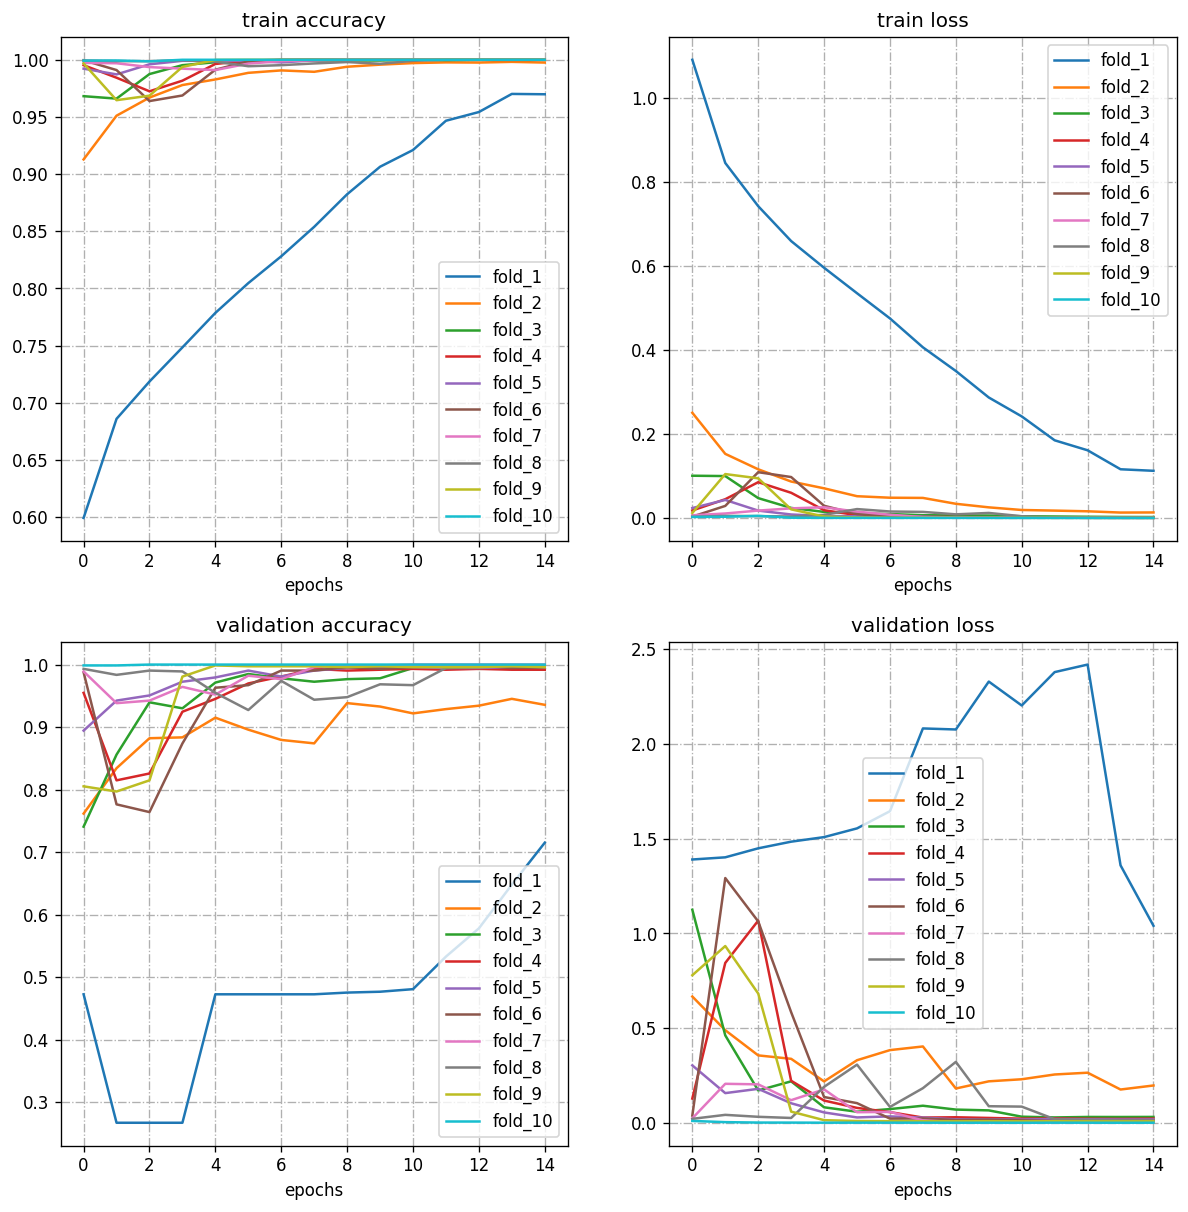

In [9]:
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []

axs[0][0].set_title('train accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][0].plot(fold_hists[i].history['acc'])
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(folds_name, fontsize = 10)


axs[0][1].set_title('train loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][1].plot(fold_hists[i].history['loss'])
axs[0][1].legend(folds_name, fontsize = 10)


axs[1][0].set_title('validation accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][0].plot(fold_hists[i].history['val_acc'])
axs[1][0].legend(folds_name, fontsize = 10)


axs[1][1].set_title('validation loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][1].plot(fold_hists[i].history['val_loss'])
axs[1][1].legend(folds_name, fontsize = 10)


# <span style="color:#e74c3c;"> Ensemble Test </span> Predictions

In [10]:
# Calculating the mean of 10 folds predictions

preds = np.mean(test_preds, axis = 0)
last_pred = np.argmax(preds, axis = 1)

# <span style="color:#e74c3c;"> Test Classification </span> Report

In [11]:
clf = classification_report(test_df['label'] , last_pred, target_names = list(fungus_classes.values()))
print(clf)

              precision    recall  f1-score   support

          H1       0.86      0.93      0.89       898
          H2       0.77      0.71      0.74       450
          H3       0.79      0.71      0.75       156
          H5       0.97      0.86      0.91       170
          H6       0.96      0.94      0.95       148

    accuracy                           0.85      1822
   macro avg       0.87      0.83      0.85      1822
weighted avg       0.85      0.85      0.85      1822



# <span style="color:#e74c3c;"> Test Confusion </span> Matrix

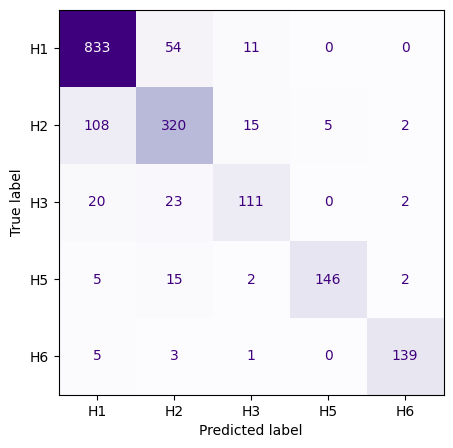

In [12]:
cm = confusion_matrix(test_df['label'] , last_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(fungus_classes.values()))

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'Purples', colorbar = False)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [13]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
    
def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(last_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(last_pred[idx[i]]) == label:
            axs[i].imshow(img) 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + fungus_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + fungus_classes[label], fontsize = 8, color = 'red')

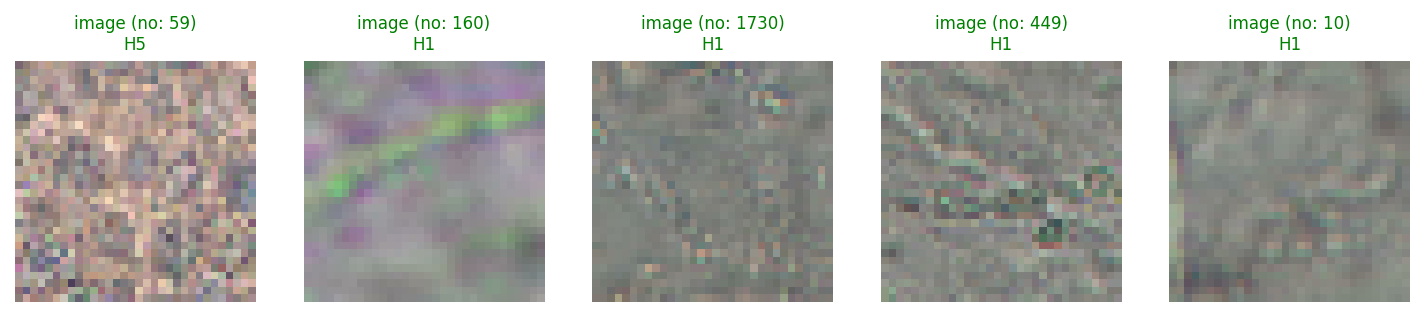

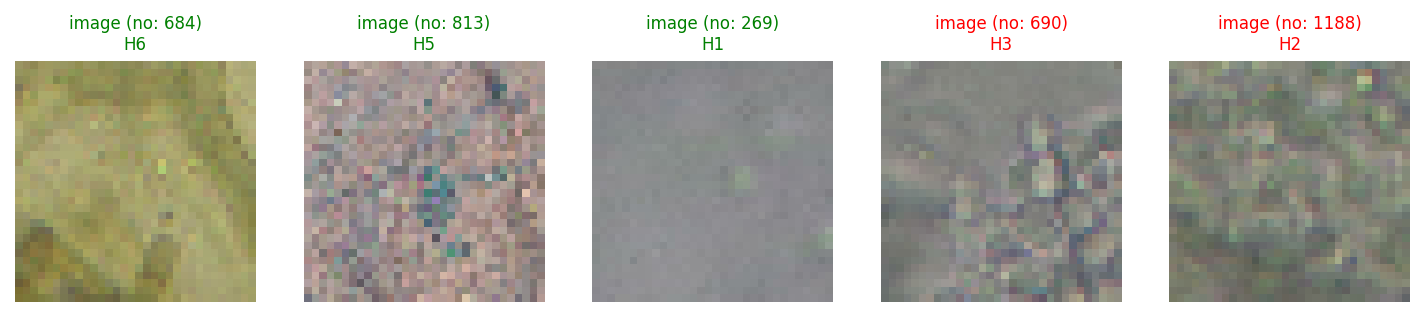

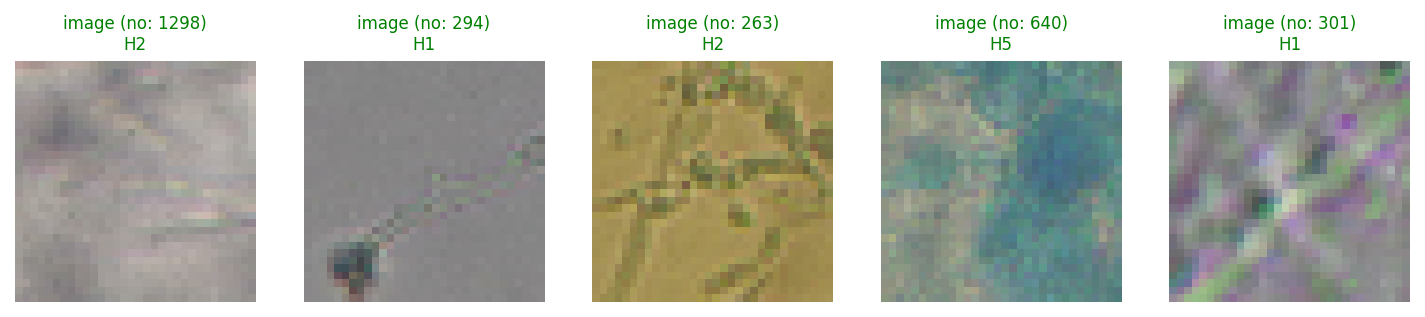

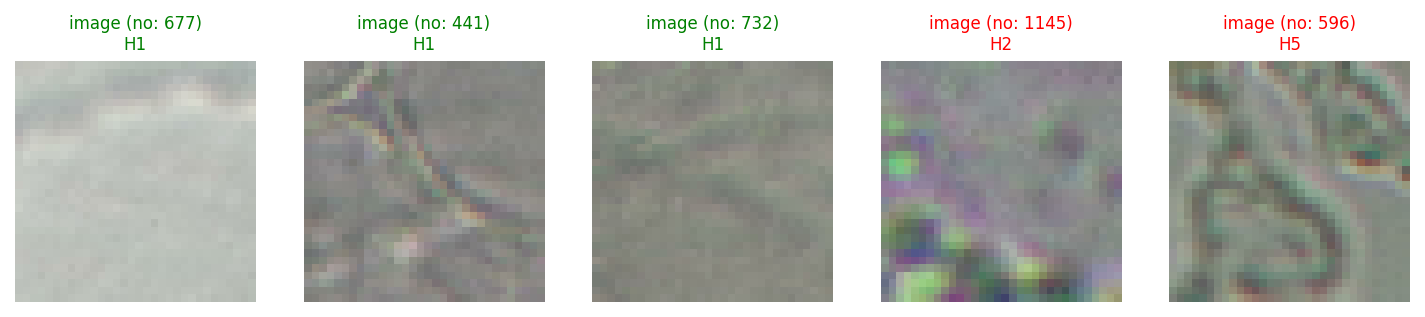

In [14]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 5)
random_test_sample_with_prediction(SEED = 10)
random_test_sample_with_prediction(SEED = 4)
random_test_sample_with_prediction(SEED = 97)

# 